In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/final_data.csv')

In [4]:
import zipfile

# Open the zip file
with zipfile.ZipFile('/content/drive/MyDrive/images3-20221221T145509Z-001.zip', 'r') as zip_ref:
    # Extract the contents to a directory
    zip_ref.extractall('/content/')

In [ ]:
import cv2
folder = '/content/images3'
image_filenames = os.listdir(folder)

X = []
y = []

for filename in image_filenames:
    try:
        isbn = filename.split('.')[0]
        rating = df[df['ISBN'] == isbn]['Book-Rating'].iloc[0]
        img = cv2.imread(f'{folder}/{filename}')
        img = cv2.resize(img, (64, 64)) 
        X.append(img)
        y.append(rating)
    except:
        print('Loading')



In [6]:
from tensorflow.keras import models, layers
print(tf.config.list_physical_devices('GPU'))
with tf.device('GPU:0'):  # specify that the block of code should run on GPU:0
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

In [8]:
X = np.asarray(X)
y = np.asarray(y)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [9]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor=tf.convert_to_tensor(X_test,dtype=tf.float32)
y_test_tensor=tf.convert_to_tensor(y_test,dtype=tf.float32)


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 1s/step - loss: 0.2227 - val_loss: 8.9356


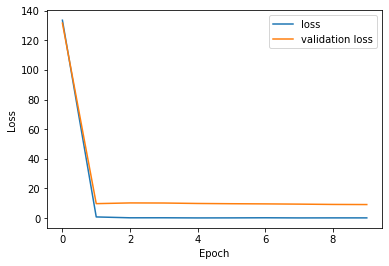

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Create a directory to store the models
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Get the number of batches in the dataset
num_batches = tf.data.experimental.cardinality(train_dataset).numpy()

# Initialize variables to keep track of the best validation accuracy and the corresponding model
best_val_loss = float("inf")
best_model = None

# Create lists to store the loss and accuracy for each epoch
loss_history = []
val_loss_history = []

# Iterate over the dataset and train the model for 10 epochs
for epoch in range(10):
    epoch_loss = []  # store the loss for each epoch
    epoch_val_loss = []  # store the validation loss for each epoch

    for _ in range(num_batches):
        X_batch, y_batch = next(iter(train_dataset))
        result = model.fit(X_batch, y_batch, epochs=1, validation_data=(X_test_tensor, y_test_tensor))  # include validation data
        epoch_loss.append(result.history["loss"])  # add loss to epoch_loss list
        epoch_val_loss.append(result.history["val_loss"])  # add validation loss to epoch_val_loss list

    # Calculate the mean loss and accuracy for the epoch
    mean_loss = np.mean(epoch_loss)
    mean_val_loss = np.mean(epoch_val_loss)

    # Append the mean loss and accuracy to the history lists
    loss_history.append(mean_loss)
    val_loss_history.append(mean_val_loss)

    # If the current validation accuracy is the best so far, save the model
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_model = model
        model.save(os.path.join(model_dir, "best_model.h5"))

# Plot the loss and accuracy over every epoch
plt.plot(loss_history, label="loss")
plt.plot(val_loss_history, label="validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Cover Image


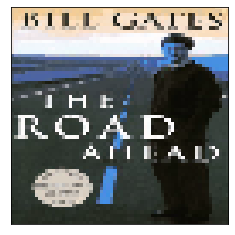

243/243 [==============================] - 1s 4ms/step
Predicted Rating:  70.27294635772705


In [28]:
print("Cover Image")
plt.imshow(X_test[10])
plt.xticks([])
plt.yticks([])
plt.show()
print("Predicted Rating: ",model.predict(X_test)[10].item())